## Importăm librăriile necesare

In [201]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import pickle
import sys
from sys import exc_info
import ast 

## Importarea și pregătirea datelor

Am descărcat setul de date MovieLens de pe Kaggle. Din acesta vom importa toate ratingurile utilizatorilor și vom filtra cele cu o apreciere de >4.

In [202]:
ratings = pd.read_csv('./Movies Data/ratings.csv', usecols = ['userId', 'movieId','rating'])
print('Forma ratingurilor: ',ratings.shape, '\n')
print("Cea mai mică valoare a ratingului: ", ratings['rating'].min())
print(ratings.head(), '\n')

Forma ratingurilor:  (468, 3) 

Cea mai mică valoare a ratingului:  4.0
   userId  movieId  rating
0       1      147     4.5
1       2       64     4.0
2       2       79     4.0
3       8        1     4.0
4       8       47     4.0 



In [203]:
ratings = ratings[ratings['rating'] >= 4.0]
print('Forma ratingurilor filtrate: ',ratings.shape, '\n')
print("Cea mai mică valoare a ratingului: ", ratings['rating'].min())
print(ratings.head(), '\n')

Forma ratingurilor filtrate:  (468, 3) 

Cea mai mică valoare a ratingului:  4.0
   userId  movieId  rating
0       1      147     4.5
1       2       64     4.0
2       2       79     4.0
3       8        1     4.0
4       8       47     4.0 



Deja avem filtrate doar filme care sunt pe placul utilizatorilr. După cum observăm, setl de date sa redus considerabil.În cele ce urmează pentru etapa de testare vom selecta doar un număr mic de filme și utilizatori pe care vom antrena modelul.

In [204]:
movies_list = np.unique(ratings['movieId'])[:200]
ratings = ratings.loc[ratings['movieId'].isin(movies_list)]
print('Forma ratingurilor pentru filmele selectate : ',ratings.shape, '\n')

Forma ratingurilor pentru filmele selectate :  (468, 3) 



Limităm în continuare datele pentru doat câțiva utilizatori.

In [205]:
users_list = np.unique(ratings['userId'])[:100]
ratings = ratings.loc[ratings['userId'].isin(users_list)]
print('Forma ratingurilor pentru utilizatorii selectați : ',ratings.shape, '\n')
print('Nr de utilizatori: ', np.unique(ratings['userId']).shape[0])
print('Nr de filme apreciate de utilizatorii selectați: ', np.unique(ratings['movieId']).shape[0])

Forma ratingurilor pentru utilizatorii selectați :  (447, 3) 

Nr de utilizatori:  100
Nr de filme apreciate de utilizatorii selectați:  83


La moment presupunem că fiecare film cu o notă de 4+ este interesant utilizatorului. Deci, dacă un film e interesant pentru utilizatorul 1 atunci acel film va fi interesant pentru utilizatorul 2 cu aceleași preferințe.

In [206]:
users_fav_movies = ratings.loc[:, ['userId', 'movieId']]

Fiind că am făcut careva modificări de aranjarea pe coloane, e important să resetăm indexii.

In [207]:
users_fav_movies = ratings.reset_index(drop = True)

Într-un final am obținut acest dataframe ce conține filmele preferate de un număr de utilizatori specificat.

In [208]:
users_fav_movies.T

,0,1,2,3,4,5,6,7,8,9,...,437,438,439,440,441,442,443,444,445,446
userId,1.0,2.0,2.0,8.0,8.0,9.0,9.0,10.0,10.0,11.0,...,153.0,153.0,155.0,155.0,156.0,156.0,156.0,156.0,156.0,157.0
movieId,147.0,64.0,79.0,1.0,47.0,1.0,150.0,150.0,165.0,34.0,...,175.0,198.0,32.0,107.0,17.0,25.0,36.0,58.0,80.0,111.0
rating,4.5,4.0,4.0,4.0,4.0,4.5,4.0,4.0,4.0,4.0,...,4.5,4.0,4.5,5.0,4.0,5.0,5.0,5.0,4.0,4.0


Acum, putem salva acest dataframa într-un fișier local de tip csv.    

In [209]:
users_fav_movies.to_csv('./Movies Data/filtered_ratings.csv')

În continuare vom crea o matrice de repartizare ce o vom utiliza în algoritmul k-means. Pentru aceasta,vom defini o funcție ce va returna lista cu filme a fiecărui utilizator

In [210]:
def moviesListForUsers(users, users_data):
    """
    Returnează o listă de filme pentru fiecare utilizator dintr-o listă de utilizatori
    Args:
        users : Listă de id-uri a utilizatorilor.
        users_data : Un dataframe cu filmele prefereate sau vizionate de utilizatori
    Returns:
        Lista de filme vizionate de utilizatori
    """

    users_movies_list = []
    for user in users:
        users_movies_list.append(str(list(users_data[users_data['userId'] == user]['movieId'])).split('[')[1].split(']')[0])
    return users_movies_list

Metoda **moviesListForUsers** ne va returna o listă de stringuri, unde fiecare șir va fi lista de filme preferate a unui utilizator. Mai târziu vmmo extrage aceste proprietăți cu  **CountVectorizer** .

Pentru a utiliza funcția de mai sus avem nevoie de o listă cu utilizatori și un dataframeul **users_data**. 

In [211]:
users = np.unique(users_fav_movies['userId'])
print(users.shape)

(100,)


Creăm lista cu filme a tuturor utilizatorilor.

In [212]:
users_movies_list = moviesListForUsers(users, users_fav_movies)
print('Listele cu filme a ', len(users_movies_list), ' utilizatori:')
print(users_movies_list[:5])

Listele cu filme a  100  utilizatori:
['147', '64, 79', '1, 47', '1, 150', '150, 165']


Primul șir conține Id-urile filmelor apreciat de primul utilizator,a doilea șir pentru al doilea utilizator și tot așa.

<p>În continuare vom crea o matrice de repartizare a filmelor vizionate de utiizatori. Dacă a fost vizionat vom nota cu 1, în caz contrar cu 0.</p>
<table class='dataframe'>
    <thead>
        <td></td>
        <td>Movie 1</td>
        <td>Movie 2</td>
        <td>Movie 3</td>
        <td>...</td>
        <td>Movie N</td>
    </thead>
    <tr>
        <td>User 1</td>
        <td>1</td>
        <td>0</td>
        <td>1</td>
        <td>...</td>
        <td>1</td>
    </tr>
    <tr>
        <td>User 2</td>
        <td>0</td>
        <td>0</td>
        <td>1</td>
        <td>...</td>
        <td>0</td>
    </tr>
    <tr>
        <td>User 3</td>
        <td>1</td>
        <td>0</td>
        <td>0</td>
        <td>...</td>
        <td>0</td>
    </tr>
</table>

Mai jos definim funcția pentru crearea matricii de repartizare

In [213]:
def sparseMatrix(list_of_str):
    """
    Crează o 'matrice de repartizare' pentru filmele preferate de utilizatori
    Args:
        list_of_str : Listă de stringuri ce conțin filmele preferate a utilizatrilor separate prin virgulă
    Returns:
        Returnează o 'matrice de repartizare' și numele caracteristicilor pe care matricea de raritate este definită
    """
    cv = CountVectorizer(token_pattern = r'[^\,\ ]+', lowercase = False)
    sp= cv.fit_transform(list_of_str)
    return sp.toarray(), cv.get_feature_names_out()

In [214]:
sparseMatrix, feature_names = sparseMatrix(users_movies_list)

Trecem datele din matricea creată într-un dataframe, care pe coloane va avea fiecare film, iar indexul fiecărui rând va fi ID-ul utilizatorilor.

In [215]:
df_sparseMatrix = pd.DataFrame(sparseMatrix, index = users, columns = feature_names)
df_sparseMatrix

,1,10,101,104,105,107,11,110,111,112,...,79,80,81,82,86,88,89,94,95,97
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
153,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
155,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
156,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


Verificăm matricea creată să ne asigurăm că toate datele introduse sunt corecte. Ne uităm la listele filmelor câtorva utilizatori.

In [216]:
some_users = users_fav_movies[users_fav_movies['userId'].isin(users[:5])].sort_values('userId')
some_users.T

,0,1,2,3,4,5,6,7,8
userId,1.0,2.0,2.0,8.0,8.0,9.0,9.0,10.0,10.0
movieId,147.0,64.0,79.0,1.0,47.0,1.0,150.0,150.0,165.0
rating,4.5,4.0,4.0,4.0,4.0,4.5,4.0,4.0,4.0


Verificăm repartiția în matrice a utilizatorilr cercetați.

In [217]:
df_sparseMatrix.loc[np.unique(some_users['userId']), list(map(str, np.unique(some_users['movieId'])))]

,1,47,64,79,147,150,165
1,0,0,0,0,1,0,0
2,0,0,1,1,0,0,0
8,1,1,0,0,0,0,0
9,1,0,0,0,0,1,0
10,0,0,0,0,0,1,1


După cum putem observa valorile din matrice și lista de filme coincid. În continuare putem să trecem la implementarea algoritmului de clusterizare.

## Clusterizare

Primul pas pentru a clusteriza datele,, este necesar de găsit numărul de clustere optimal. Pentru a realiza acest lucru creăm o clasa ce implementează metoda elbow prin rularea algoritmlui k-means și care afișează grafic rezultatele.

In [218]:
class elbowMethod():
    def __init__(self, sparseMatrix):
        self.sparseMatrix = sparseMatrix
        self.wcss = list()
        self.differences = list()
    def run(self, init, upto, max_iterations = 300):
        for i in range(init, upto + 1):
            kmeans = KMeans(n_clusters=i, init = 'k-means++', max_iter = max_iterations, n_init = 10, random_state = 0)
            kmeans.fit(sparseMatrix)
            self.wcss.append(kmeans.inertia_)
        self.differences = list()
        for i in range(len(self.wcss)-1):
            self.differences.append(self.wcss[i] - self.wcss[i+1])
    def showPlot(self, boundary = 500, upto_cluster = None):
        if upto_cluster is None:
            WCSS = self.wcss
            DIFF = self.differences
        else:
            WCSS = self.wcss[:upto_cluster]
            DIFF = self.differences[:upto_cluster - 1]
        plt.figure(figsize=(15, 6))
        plt.subplot(121).set_title("Metoda 'Elbow' ")
        plt.plot(range(1, len(WCSS) + 1), WCSS)
        plt.grid(visible=  True)
        plt.subplot(122).set_title('Diferența între câte 2 clustere consecutive')
        len_differences = len(DIFF)
        X_differences = range(1, len_differences + 1)
        plt.plot(X_differences, DIFF)
        plt.plot(X_differences, np.ones(len_differences)*boundary, 'r')
        plt.plot(X_differences, np.ones(len_differences)*(-boundary), 'r')
        plt.grid()
        plt.show()
        

Fiindcă nu cunoaștem în ce interval vom obține numărul de clustere optimal cu metoda elbow, avem o proprietate listă în care salvăm valorile WCSS calculate. Dacă prima dată rulăm metoda pe intervalul 1-10 și mai târziu când vizualizăm graficul nu putem depista punctul optim, vom rula mai departe pe 11-20 și tot așa până ajungem la un rezultat satisfăcător, 

Pe lângă metoda de bază, vom mai utiliza o strategie când nu putem depista un "cot". Aceasta constă din diferența dintre cele 2 valori WCSS. Ptem seta o limită pentru a observa clar diferențele de valoare. Deci, atunci când schimbările valorii WCSS rămân în limitele specificate, am depistat punctul după care modificările dintre nr de clustere sunt mici și nesemneficative.

Analizăm algoritmul pentru un intrval 1-10 de clustere. Prima dată k-means va rula pentru *k=1* clustere, apoi pentru *k=2* clustere și tot așa până la *k=10*. Setăm diferența acceptabilă ca 10. 

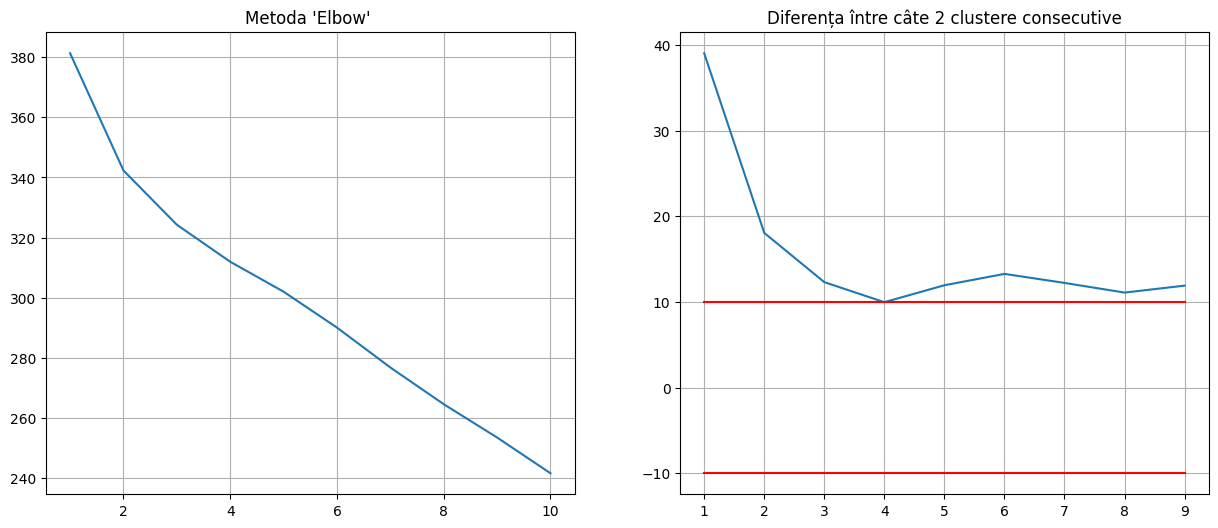

In [219]:
elbow_method = elbowMethod(sparseMatrix)
elbow_method.run(1, 10)
elbow_method.showPlot(boundary = 10)

Fiindcă nu se obervă în schemă valoarea optimă și nu avem o consecutivitate de scimbări în cadrul limitei stabilite, verificăm mai departe pe intervalul 11-20.

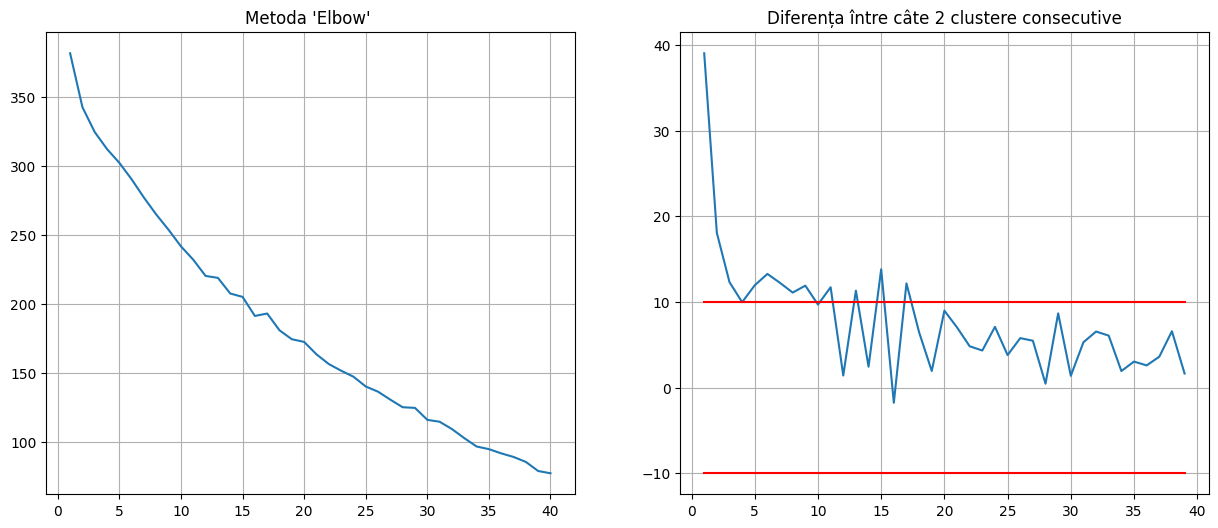

In [220]:
elbow_method.run(11, 40)
elbow_method.showPlot(boundary = 10)

Nu se observă punctul căutat în elbow, însă avem diferențe în limitele stabilite. Dacă ne uită în al doilea graf, vedem că după clusterul 26, toate diferențele sunt în limita stabilită. Deci vom rula **k-means** pentru 27 clustere.

## Implementarea modelului cu date 

Rulăm modelul k-means pentru a face predicțiile.

In [221]:
nr_of_clusters=15
kmeans = KMeans(n_clusters=nr_of_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
clusters = kmeans.fit_predict(sparseMatrix)

Introducem rezultatele într-un dataframe pentru a vizualiza numărul fiecărui cluster.

In [222]:
users_cluster = pd.DataFrame(np.concatenate((users.reshape(-1,1), clusters.reshape(-1,1)), axis = 1), columns = ['userId', 'Cluster'])
users_cluster.T

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
userId,1,2,8,9,10,11,12,15,16,18,...,134,137,142,146,150,151,153,155,156,157
Cluster,13,14,1,9,4,14,11,14,5,13,...,14,14,2,14,7,14,9,5,14,14


În continuare definim o funcție care va crea listă de dataframe-uri, unde fiecare va avea id-l filmului și numărul de aprecieri a acestuia (**count** - numărul de utilizatori care are filmul ca favorit). Deci filmul cu valarea **count** cea mai mare va fi mai interesant pentru cei ce nu lau vizonat încă.
<br>
Vom avea lista de tipul: [dataframe_Cluster_1, dataframe_Cluster_2, ..., dataframe_Cluster_3]
<br>
Fiecare dataframe va fi de tipul:
<table class='dataframe'>
        <thead>
                <td>Index</td>
                <td>ID Film</td>
                <td>Count</td>
        </thead>
        <tr>
                <td>0</td>
                <td>121</td>
                <td>100</td>
        </tr>
        <tr>
                <td>1</td>
                <td>8786</td>
                <td>95</td>
        </tr>
        <tr>
                <td>&#8942;</td>
                <td>&#8942;</td>
                <td>&#8942;</td>
        </tr>
        <tr>
                <td>N</td>
                <td>Id ultimul film</td>
                <td>Nr de aprecieri</td>
        </tr>
</table>

Pentru a crea o listă cu filmele utilizatorilor dintr-un anumit cluster,cream o funcție ce face acest lucru.

In [223]:
def clustersMovies(users_cluster, users_data):
    clusters = list(users_cluster['Cluster'])
    each_cluster_movies = list()
    for i in range(len(np.unique(clusters))):
        users_list = list(users_cluster[users_cluster['Cluster'] == i]['userId'])
        users_movies_list = list()
        for user in users_list:    
            users_movies_list.extend(list(users_data[users_data['userId'] == user]['movieId']))
        users_movies_counts = list()
        users_movies_counts.extend([[movie, users_movies_list.count(movie)] for movie in np.unique(users_movies_list)])
        each_cluster_movies.append(pd.DataFrame(users_movies_counts, columns=['movieId', 'Count']).sort_values(by = ['Count'], ascending = False).reset_index(drop=True))
    return each_cluster_movies

In [224]:
cluster_movies = clustersMovies(users_cluster, users_fav_movies)

Un exemplu de dataframe a unui cluster din lista **cluster_movies**. 

In [225]:
cluster_movies[1].T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
movieId,1,50,47,5,111,95,6,36,21,62,2,110,151,158,161,165,186,188
Count,12,6,4,3,2,2,2,1,1,1,1,1,1,1,1,1,1,1


Avem 17 filme în acest cluster unde filmul cu ID-ul 1 e favorit la 12 utilizatori.

Să vedem câti utilizatori sunt în fiecare cluster.

In [226]:
for i in range(nr_of_clusters):
    len_users = users_cluster[users_cluster['Cluster'] == i].shape[0]
    print('Utilizatori în Clusterul ' + str(i) + ' -> ', len_users)

Utilizatori în Clusterul 0 ->  2
Utilizatori în Clusterul 1 ->  12
Utilizatori în Clusterul 2 ->  13
Utilizatori în Clusterul 3 ->  1
Utilizatori în Clusterul 4 ->  6
Utilizatori în Clusterul 5 ->  9
Utilizatori în Clusterul 6 ->  1
Utilizatori în Clusterul 7 ->  1
Utilizatori în Clusterul 8 ->  1
Utilizatori în Clusterul 9 ->  7
Utilizatori în Clusterul 10 ->  2
Utilizatori în Clusterul 11 ->  1
Utilizatori în Clusterul 12 ->  2
Utilizatori în Clusterul 13 ->  12
Utilizatori în Clusterul 14 ->  30


După cum se obervă există cluster cu un numar mic de utilizatori (1-2). NU ne dorim astfel de clustere mici fiindcă nu vom avea posibilitatea de a recomanda decât un număr restrâns de filme. Deci apare necesitatea de a rezolva acești clusteri nefolositori.

### Rezolvarea Clusterilor Mici

Să zicem că nu dorim nici un cluster cu un singur utilizator sau cu mai puțin de 6 utilizatori. Deci trebuie să mutăm utilizatorii din clusterele mici în altele mai largi, care e ce mai relevant pentru utilizatorul dat.

Cream o funcție ce ne returneaza lista de filme favorite a unui singur utilizator.

In [227]:
def getMoviesOfUser(user_id, users_data):
    return list(users_data[users_data['userId'] == user_id]['movieId'])

Mai departe cream funcția ce se va ocupa de rezolvarea clusterilor mici.

In [228]:
def fixClusters(clusters_movies_dataframes, users_cluster_dataframe, users_data, smallest_cluster_size = 11):
    """
    Mută utilizatorii din clusterele mici în clusterele mari
    Args:
        clusters_movies_dataframes : Listă de datafreme-uri ce conțin filmele preferate de utilizatori din fiecare cluster
        users_cluster_dataframe : Un dataframe cu ID-ul utilizatorilor și clusterele lor
        smallest_cluster_size : Dimensiunea minimă a unui cluster pentru a nu fi eliminat
    Returns:
        each_cluster_movies : Listă de datafreme-uri ce conțin filmele preferate de utilizatori din fiecare cluster
        users_cluster : Un dataframe cu ID-ul utilizatorilor și clusterele lor
    """
 
    each_cluster_movies = clusters_movies_dataframes.copy()
    users_cluster = users_cluster_dataframe.copy()
    
    # Covertim fiecare dataframe din each_cluster_movies într-o listă care conține doar ID-urile filmelor
    each_cluster_movies_list = [list(df['movieId']) for df in each_cluster_movies]
    
    # Pregătim o listă care conține listele de utilizatori din fiecare cluster -> [[Utilizatori din Cluster 0], [Utilizatori din Cluster 1], ... ,[Utilizatori din Cluster N]] 
    usersInClusters = list()
    total_clusters = len(each_cluster_movies)
    for i in range(total_clusters):
        usersInClusters.append(list(users_cluster[users_cluster['Cluster'] == i]['userId']))
    uncategorizedUsers = list()
    i = 0
    
    # Eliminăm clusterele mici și mutăm utilizatorii lor într-o listă numită "uncategorizedUsers"
    # Când vom elimina un cluster, atunci trebuie să actualizăm numerele de clustere ale utilizatorilor  după ștergerea clusterului
    # De exemplu, dacă am șters clusterul 4, atunci vor fi utilizatori ale căror clustere vor fi 5,6,7,..,N. Deci, vom aduce înapoi numărul de clustere ale acestor utilizatori la 4,5,6,...,N-1.
    for j in range(total_clusters):
        if len(usersInClusters[i]) < smallest_cluster_size:
            uncategorizedUsers.extend(usersInClusters[i])
            usersInClusters.pop(i)
            each_cluster_movies.pop(i)
            each_cluster_movies_list.pop(i)
            users_cluster.loc[users_cluster['Cluster'] > i, 'Cluster'] -= 1
            i -= 1
        i += 1
    for user in uncategorizedUsers:
        elemProbability = list()
        user_movies = getMoviesOfUser(user, users_data)
        if len(user_movies) == 0:
            print(user)
        user_missed_movies = list()
        for movies_list in each_cluster_movies_list:
            count = 0
            missed_movies = list()
            for movie in user_movies:
                if movie in movies_list:
                    count += 1
                else:
                    missed_movies.append(movie)
            elemProbability.append(count / len(user_movies))
            user_missed_movies.append(missed_movies)
        user_new_cluster = np.array(elemProbability).argmax()
        users_cluster.loc[users_cluster['userId'] == user, 'Cluster'] = user_new_cluster
        if len(user_missed_movies[user_new_cluster]) > 0:
           each_cluster_movies[user_new_cluster] = pd.concat([each_cluster_movies[user_new_cluster], pd.DataFrame([{'movieId': new_movie, 'Count': 1} for new_movie in user_missed_movies[user_new_cluster]])], ignore_index=True)

    return each_cluster_movies, users_cluster


In [229]:
movies_df_fixed, clusters_fixed = fixClusters(cluster_movies, users_cluster, users_fav_movies, smallest_cluster_size = 6)

Analizăm datele care leamm avut înainte de mutarea între clustere șii cea după.

In [230]:
j = 0
for i in range(nr_of_clusters):
    len_users = users_cluster[users_cluster['Cluster'] == i].shape[0]
    if len_users < 6:
        print('Utilizatori în Clusterrul ' + str(i) + ' -> ', len_users)
        j += 1
print('Numărul de clustere ce le vom elimina -> ', j)

Utilizatori în Clusterrul 0 ->  2
Utilizatori în Clusterrul 3 ->  1
Utilizatori în Clusterrul 6 ->  1
Utilizatori în Clusterrul 7 ->  1
Utilizatori în Clusterrul 8 ->  1
Utilizatori în Clusterrul 10 ->  2
Utilizatori în Clusterrul 11 ->  1
Utilizatori în Clusterrul 12 ->  2
Numărul de clustere ce le vom elimina ->  8


In [231]:
print('Numărul total de clustere inițiale -> ', len(cluster_movies))
users_cluster.T

Numărul total de clustere inițiale ->  15


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
userId,1,2,8,9,10,11,12,15,16,18,...,134,137,142,146,150,151,153,155,156,157
Cluster,13,14,1,9,4,14,11,14,5,13,...,14,14,2,14,7,14,9,5,14,14


După ce rezolvăm și eliminăm clusterele mici. 

In [232]:
print('Numărul total de clustere ce au rămas -> ', len(movies_df_fixed))
clusters_fixed.T

Numărul total de clustere ce au rămas ->  7


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
userId,1,2,8,9,10,11,12,15,16,18,...,134,137,142,146,150,151,153,155,156,157
Cluster,5,6,0,4,2,6,1,6,3,5,...,6,6,1,6,1,6,4,3,6,6


Să verificăm dimensiunile noilor clusteri.

In [233]:
for i in range(len(movies_df_fixed)):
    len_users = clusters_fixed[clusters_fixed['Cluster'] == i].shape[0]
    print('Utilizatori în Clusterul ' + str(i) + ' -> ', len_users)

Utilizatori în Clusterul 0 ->  12
Utilizatori în Clusterul 1 ->  19
Utilizatori în Clusterul 2 ->  8
Utilizatori în Clusterul 3 ->  10
Utilizatori în Clusterul 4 ->  7
Utilizatori în Clusterul 5 ->  12
Utilizatori în Clusterul 6 ->  32


Fiecare cluster deja are destui utilizatori ca să putem face recomandări altor utilizatori. Deci există și detule filme în fiecare cluster.

In [234]:
for i in range(len(movies_df_fixed)):
    print('Numărul total de filme în Clusterul ' + str(i) + ' -> ', movies_df_fixed[i].shape[0])

Numărul total de filme în Clusterul 0 ->  18
Numărul total de filme în Clusterul 1 ->  65
Numărul total de filme în Clusterul 2 ->  33
Numărul total de filme în Clusterul 3 ->  21
Numărul total de filme în Clusterul 4 ->  24
Numărul total de filme în Clusterul 5 ->  15
Numărul total de filme în Clusterul 6 ->  32


După ce am cream modelul pe baza k-means să facă predicții pentru fiecare utilizator, este necesar să salvăm aceste rezultate pentru a putea fi utilizate ulterior. Pentru aceasta utilizăm librăria **Pickle** pentru serializarea informației necesare.

Definim funcții de salvare și încărcare a fișierelor cu clusterele deja create.

In [235]:
class saveLoadFiles:
    def save(self, filename, data):
        try:
            file = open('datasets/' + filename + '.pkl', 'wb')
            pickle.dump(data, file)
        except:
            err = 'Error: {0}, {1}'.format(exc_info()[0], exc_info()[1])
            print(err)
            file.close()
            return [False, err]
        else:
            file.close()
            return [True]
    def load(self, filename):
        try:
            file = open('datasets/' + filename + '.pkl', 'rb')
        except:
            err = 'Error: {0}, {1}'.format(exc_info()[0], exc_info()[1])
            print(err)
            file.close()
            return [False, err]
        else:
            data = pickle.load(file)
            file.close()
            return data
    def loadClusterMoviesDataset(self):
        return self.load('clusters_movies_dataset')
    def saveClusterMoviesDataset(self, data):
        return self.save('clusters_movies_dataset', data)
    def loadUsersClusters(self):
        return self.load('users_clusters')
    def saveUsersClusters(self, data):
        return self.save('users_clusters', data)

Verificăm dacă are loc stocarea și încărcarea datelor.

In [236]:
saveLoadFile = saveLoadFiles()
print(saveLoadFile.saveClusterMoviesDataset(movies_df_fixed))
print(saveLoadFile.saveUsersClusters(clusters_fixed))

[True]
[True]


## Generarea recomandărilor utilizatorilor

Cream  metodă de a genera recomandări dintr-un cluster cu cele mai aprciate filme nevizionate de utilizator.

In [237]:
class userRequestedFor:
    def __init__(self, user_id, users_data):
        self.users_data = users_data.copy()
        self.user_id = user_id
        # Cautăm clusterul utilizatorului
        users_cluster = saveLoadFiles().loadUsersClusters()
                
        self.user_cluster = ((users_cluster[users_cluster['userId'] == self.user_id]['Cluster']).iloc[0].astype(int))
        # Încărcăm lista de filme pentru clusterul utilizatorului
        self.movies_list = saveLoadFiles().loadClusterMoviesDataset()
        self.cluster_movies = self.movies_list[self.user_cluster] # dataframe
        self.cluster_movies_list = list(self.cluster_movies['movieId']) # list
        
    def updatedFavouriteMoviesList(self, new_movie_Id):
        if new_movie_Id in self.cluster_movies_list:
            self.cluster_movies.loc[self.cluster_movies['movieId'] == new_movie_Id, 'Count'] += 1
        else:
            self.cluster_movies = self.cluster_movies.append([{'movieId':new_movie_Id, 'Count': 1}], ignore_index=True)
        self.cluster_movies.sort_values(by = ['Count'], ascending = False, inplace= True)
        self.movies_list[self.user_cluster] = self.cluster_movies
        saveLoadFiles().saveClusterMoviesDataset(self.movies_list)

    def recommendMostFavouriteMovies(self):
        try:
            user_movies = getMoviesOfUser(self.user_id, self.users_data)
            cluster_movies_list = self.cluster_movies_list.copy()
            for user_movie in user_movies:
                if user_movie in cluster_movies_list:
                    cluster_movies_list.remove(user_movie)
            return [True, cluster_movies_list]
        except KeyError:
            err = "User history does not exist"
            print(err)
            return [False, err]
        except:
            err = 'Error: {0}, {1}'.format(exc_info()[0], exc_info()[1])
            print(err)
            return [False, err]

Pentru a afișa recomandări mai depline nu încărcăm doar id-urile filmelor, ci și alte date cum ar fi titlu, genurle etc. 

In [238]:
movies_metadata = pd.read_csv(
    './Movies Data/movies_metadata.csv', 
    usecols = ['id', 'genres', 'original_title'])

movies_metadata = movies_metadata.loc[
    movies_metadata['id'].isin(list(map(str, np.unique(users_fav_movies['movieId']))))].reset_index(drop=True)
movies_metadata.head()

,genres,id,original_title
0,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",5,Four Rooms
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",11,Star Wars
2,"[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n...",101,Léon
3,"[{'id': 18, 'name': 'Drama'}, {'id': 9648, 'na...",110,Trois couleurs : Rouge
4,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",6,Judgment Night


Lista de filme preferate a utilizatorului cu ID-ul 12.

In [239]:
userMovies = getMoviesOfUser(12, users_fav_movies)
for movie in userMovies:
    title = list(movies_metadata.loc[movies_metadata['id'] == str(movie)]['original_title'])
    if title != []:
        print('Titlul: ', title, ', Genuri: [', end = '')
        genres = ast.literal_eval(movies_metadata.loc[movies_metadata['id'] == str(movie)]['genres'].values[0].split('[')[1].split(']')[0])
        for genre in genres:
            print(genre['name'], ', ', end = '')
        print(end = '\b\b]')
        print('')

Titlul:  ['Dancer in the Dark'] , Genuri: [Drama , Crime , Music ]
Titlul:  ['The Dark'] , Genuri: [Horror , Thriller , Mystery ]
Titlul:  ['Miami Vice'] , Genuri: [Action , Adventure , Crime , Thriller ]
Titlul:  ['Tron'] , Genuri: [Science Fiction , Action , Adventure ]
Titlul:  ['The Lord of the Rings'] , Genuri: [Fantasy , Drama , Animation , Adventure ]
Titlul:  ['48 Hrs.'] , Genuri: [Thriller , Action , Comedy , Crime , Drama ]
Titlul:  ['Edward Scissorhands'] , Genuri: [Fantasy , Drama , Romance ]
Titlul:  ['Le Grand Bleu'] , Genuri: [Adventure , Drama , Romance ]
Titlul:  ['Saw'] , Genuri: [Horror , Mystery , Crime ]
Titlul:  ["Le fabuleux destin d'Amélie Poulain"] , Genuri: [Comedy , Romance ]


Top recomandări pentru utilizatorul cu ID-ul 12.

In [240]:
userRecommendations = userRequestedFor(12, users_fav_movies).recommendMostFavouriteMovies()[1]
for movie in userRecommendations[:10]:
    title = list(movies_metadata.loc[movies_metadata['id'] == str(movie)]['original_title'])
    if title != []:
        print('Titlul: ', title, ', Genuri: [', end = '')
        genres = ast.literal_eval(movies_metadata.loc[movies_metadata['id'] == str(movie)]['genres'].values[0].split('[')[1].split(']')[0])
        for genre in genres:
            print(genre['name'], ', ', end = '')
        print(']', end = '')
        print()
            

Titlul:  ['Trois couleurs : Rouge'] , Genuri: [Drama , Mystery , Romance , ]
Titlul:  ['Scarface'] , Genuri: [Action , Crime , Drama , Thriller , ]
Titlul:  ['Judgment Night'] , Genuri: [Action , Thriller , Crime , ]
Titlul:  ['To Be or Not to Be'] , Genuri: [Comedy , War , ]
Titlul:  ["Ocean's Twelve"] , Genuri: [Thriller , Crime , ]
Titlul:  ['Kill Bill: Vol. 1'] , Genuri: [Action , Crime , ]
Titlul:  ['Star Trek V: The Final Frontier'] , Genuri: [Science Fiction , Action , Adventure , Thriller , ]
